# Instance Detection with RetinaNet

We are going to implement [RetinaNet by Lin et al., 2017](https://arxiv.org/abs/1708.02002) for [COCO dataset](http://cocodataset.org/) instance detection.

## Import the required libraries

In [1]:
import tempfile

import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision
from matplotlib import pyplot as plt

import fastestimator as fe

In [2]:
#training parameters
data_dir=None
batch_size = 16
epochs = 13
image_size=512
num_classes=90
train_steps_per_epoch = None
eval_steps_per_epoch = None
model_dir=tempfile.mkdtemp()
class_json_path = 'class.json'

## Step 1 - Data and `Pipeline` preparation

### Load data

The `class.json` includes a map for the class number and what object the number corresponds to.

In [3]:
import json

with open(class_json_path, 'r') as f:
    class_map = json.load(f)

We call our `mscoco` data API to obtain the training and validation set:
* 118287 images for training
* 5000 images for validation

In [4]:
from fastestimator.dataset.data import mscoco

train_ds, eval_ds = mscoco.load_data(root_dir=data_dir)
print(len(train_ds)) # 118287
print(len(eval_ds)) # 5000

118287
5000


### Generate Anchors

Anchors are predefined for each pixel in the feature map. In this apphub our backbone is ResNet-50, so we can precompute all the anchors we need for training.

In [5]:
def _get_fpn_anchor_box(width, height):
    assert height % 32 == 0 and width % 32 == 0
    shapes = [(int(height / 8), int(width / 8))]  # P3
    num_pixel = [np.prod(shapes)]
    anchor_lengths = [32, 64, 128, 256, 512]
    for _ in range(4):  # P4 through P7
        shapes.append((int(np.ceil(shapes[-1][0] / 2)), int(np.ceil(shapes[-1][1] / 2))))
        num_pixel.append(np.prod(shapes[-1]))
    total_num_pixels = np.sum(num_pixel)
    anchorbox = np.zeros((9 * total_num_pixels, 4))
    anchor_length_multipliers = [2**(0.0), 2**(1 / 3), 2**(2 / 3)]
    aspect_ratios = [1.0, 2.0, 0.5]  #x:y
    anchor_idx = 0
    for shape, anchor_length in zip(shapes, anchor_lengths):
        p_h, p_w = shape
        base_y = 2**np.ceil(np.log2(height / p_h))
        base_x = 2**np.ceil(np.log2(width / p_w))
        for i in range(p_h):
            center_y = (i + 1 / 2) * base_y
            for j in range(p_w):
                center_x = (j + 1 / 2) * base_x
                for anchor_length_multiplier in anchor_length_multipliers:
                    area = (anchor_length * anchor_length_multiplier)**2
                    for aspect_ratio in aspect_ratios:
                        x1 = center_x - np.sqrt(area * aspect_ratio) / 2
                        y1 = center_y - np.sqrt(area / aspect_ratio) / 2
                        x2 = center_x + np.sqrt(area * aspect_ratio) / 2
                        y2 = center_y + np.sqrt(area / aspect_ratio) / 2
                        anchorbox[anchor_idx, 0] = x1
                        anchorbox[anchor_idx, 1] = y1
                        anchorbox[anchor_idx, 2] = x2 - x1
                        anchorbox[anchor_idx, 3] = y2 - y1
                        anchor_idx += 1
        if p_h == 1 and p_w == 1:  # the next level of 1x1 feature map is still 1x1, therefore ignore
            break
    return np.float32(anchorbox), np.int32(num_pixel) * 9

In [6]:
from fastestimator.op.numpyop import NumpyOp

class ShiftLabel(NumpyOp):
    def forward(self, data, state):
        # the label of COCO dataset starts from 1, shifting the start to 0
        bbox = np.array(data, dtype=np.float32)
        bbox[:, -1] = bbox[:, -1] - 1
        return bbox


class AnchorBox(NumpyOp):
    def __init__(self, width, height, inputs, outputs, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.anchorbox, _ = _get_fpn_anchor_box(width, height)  # anchorbox is #num_anchor x 4

    def forward(self, data, state):
        target = self._generate_target(data)  # bbox is #obj x 5
        return np.float32(target)

    def _generate_target(self, bbox):
        object_boxes = bbox[:, :-1]  # num_obj x 4
        label = bbox[:, -1]  # num_obj x 1
        ious = self._get_iou(object_boxes, self.anchorbox)  # num_obj x num_anchor
        #now for each object in image, assign the anchor box with highest iou to them
        anchorbox_best_iou_idx = np.argmax(ious, axis=1)
        num_obj = ious.shape[0]
        for row in range(num_obj):
            ious[row, anchorbox_best_iou_idx[row]] = 0.99
        #next, begin the anchor box assignment based on iou
        anchor_to_obj_idx = np.argmax(ious, axis=0)  # num_anchor x 1
        anchor_best_iou = np.max(ious, axis=0)  # num_anchor x 1
        cls_gt = np.int32([label[idx] for idx in anchor_to_obj_idx])  # num_anchor x 1
        cls_gt[np.where(anchor_best_iou <= 0.4)] = -1  #background class
        cls_gt[np.where(np.logical_and(anchor_best_iou > 0.4, anchor_best_iou <= 0.5))] = -2  # ignore these examples
        #finally, calculate localization target
        single_loc_gt = object_boxes[anchor_to_obj_idx]  # num_anchor x 4
        gt_x1, gt_y1, gt_width, gt_height = np.split(single_loc_gt, 4, axis=1)
        ac_x1, ac_y1, ac_width, ac_height = np.split(self.anchorbox, 4, axis=1)
        dx1 = np.squeeze((gt_x1 - ac_x1) / ac_width)
        dy1 = np.squeeze((gt_y1 - ac_y1) / ac_height)
        dwidth = np.squeeze(np.log(gt_width / ac_width))
        dheight = np.squeeze(np.log(gt_height / ac_height))
        return np.array([dx1, dy1, dwidth, dheight, cls_gt]).T  # num_anchor x 5

    @staticmethod
    def _get_iou(boxes1, boxes2):
        """Computes the value of intersection over union (IoU) of two array of boxes.
        Args:
            box1 (array): first boxes in N x 4
            box2 (array): second box in M x 4
        Returns:
            float: IoU value in N x M
        """
        x11, y11, w1, h1 = np.split(boxes1, 4, axis=1)
        x21, y21, w2, h2 = np.split(boxes2, 4, axis=1)
        x12 = x11 + w1
        y12 = y11 + h1
        x22 = x21 + w2
        y22 = y21 + h2
        xmin = np.maximum(x11, np.transpose(x21))
        ymin = np.maximum(y11, np.transpose(y21))
        xmax = np.minimum(x12, np.transpose(x22))
        ymax = np.minimum(y12, np.transpose(y22))
        inter_area = np.maximum((xmax - xmin + 1), 0) * np.maximum((ymax - ymin + 1), 0)
        area1 = (w1 + 1) * (h1 + 1)
        area2 = (w2 + 1) * (h2 + 1)
        iou = inter_area / (area1 + area2.T - inter_area)
        return iou

### `Pipeline`

For our data pipeline, we resize the images such that the longer side is 512 pixels. We keep the aspect ratio the same as original image, so on the shorter side we pad zeros. The resized image is 512 by 512. For data augmentation we only flip the image horizontally. 

In [7]:
from albumentations import BboxParams

from fastestimator.op.numpyop import Batch
from fastestimator.op.numpyop.meta import Sometimes
from fastestimator.op.numpyop.multivariate import HorizontalFlip, LongestMaxSize, PadIfNeeded
from fastestimator.op.numpyop.univariate import ChannelTranspose, Normalize, ReadImage

pipeline = fe.Pipeline(
    train_data=train_ds,
    eval_data=eval_ds,
    ops=[
        ReadImage(inputs="image", outputs="image"),
        LongestMaxSize(image_size, image_in="image", image_out="image", bbox_in="bbox", bbox_out="bbox", bbox_params=BboxParams("coco", min_area=1.0)),
        PadIfNeeded(image_size, image_size, border_mode=cv2.BORDER_CONSTANT, image_in="image", image_out="image", bbox_in="bbox", bbox_out="bbox",bbox_params=BboxParams("coco", min_area=1.0)),
        Sometimes(HorizontalFlip(mode="train", image_in="image", image_out="image", bbox_in="bbox", bbox_out="bbox", bbox_params='coco')),
        Normalize(inputs="image", outputs="image", mean=1.0, std=1.0, max_pixel_value=127.5),
        ShiftLabel(inputs="bbox", outputs="bbox"),
        AnchorBox(inputs="bbox", outputs="anchorbox", width=image_size, height=image_size),
        ChannelTranspose(inputs="image", outputs="image"),
        Batch(batch_size=batch_size, pad_value=0)
    ])

### Visualization of batch data

In [8]:
batch_data = pipeline.get_results(mode='eval', num_steps=2)

id = 872


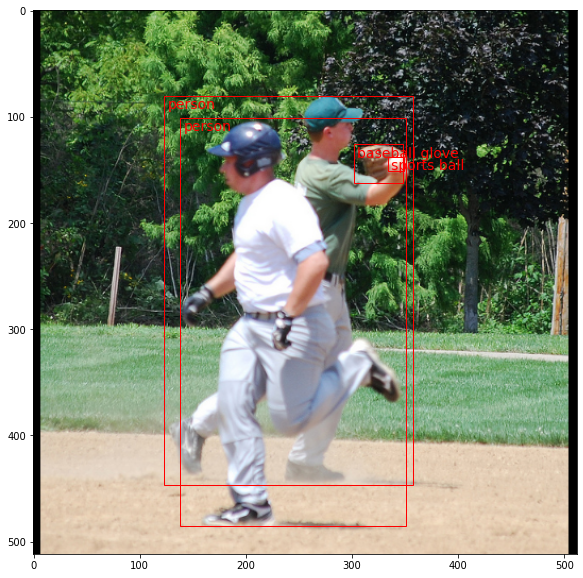

In [9]:
import matplotlib.patches as patches

step_index = 0
batch_index = 7

img = batch_data[step_index]['image'][batch_index].numpy()
img = ((img + 1)/2 * 255).astype(np.uint8)
img = np.transpose(img, [1, 2, 0])

keep = ~np.all(batch_data[step_index]['bbox'][batch_index].numpy() == 0, axis=1)
x1, y1, w, h, label = batch_data[step_index]['bbox'][batch_index].numpy()[keep].T

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)
for j in range(len(x1)):
    rect = patches.Rectangle((x1[j], y1[j]),w[j],h[j],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    ax.text(x1[j] + 3, y1[j] + 12, class_map[str(int(label[j]+1))], color=(1, 0, 0), fontsize=14)


print("id = {}".format(batch_data[step_index]['image_id'][batch_index].numpy()))

## Step 2 - `Network` construction

### Class and box subnets

We define the classification (class) subnet and regression (box) subnet. See Fig. 3 of the original paper.

In [10]:
class ClassificationSubNet(nn.Module):
    def __init__(self, in_channels, num_classes, num_anchors=9):
        super().__init__()
        self.num_classes = num_classes
        self.conv2d_1 = nn.Conv2d(in_channels, 256, 3, padding=1)
        nn.init.normal_(self.conv2d_1.weight.data, std=0.01)
        nn.init.zeros_(self.conv2d_1.bias.data)
        self.conv2d_2 = nn.Conv2d(256, 256, 3, padding=1)
        nn.init.normal_(self.conv2d_2.weight.data, std=0.01)
        nn.init.zeros_(self.conv2d_2.bias.data)
        self.conv2d_3 = nn.Conv2d(256, 256, 3, padding=1)
        nn.init.normal_(self.conv2d_3.weight.data, std=0.01)
        nn.init.zeros_(self.conv2d_3.bias.data)
        self.conv2d_4 = nn.Conv2d(256, 256, 3, padding=1)
        nn.init.normal_(self.conv2d_4.weight.data, std=0.01)
        nn.init.zeros_(self.conv2d_4.bias.data)
        self.conv2d_5 = nn.Conv2d(256, num_classes * num_anchors, 3, padding=1)
        nn.init.normal_(self.conv2d_5.weight.data, std=0.01)
        nn.init.constant_(self.conv2d_5.bias.data, val=np.log(1 / 99))

    def forward(self, x):
        x = self.conv2d_1(x)
        x = nn.functional.relu(x)
        x = self.conv2d_2(x)
        x = nn.functional.relu(x)
        x = self.conv2d_3(x)
        x = nn.functional.relu(x)
        x = self.conv2d_4(x)
        x = nn.functional.relu(x)
        x = self.conv2d_5(x)
        x = torch.sigmoid(x)
        x = x.permute(0, 2, 3, 1)  # [8, c, h, w] -> [8, h, w, c] , to make reshape meaningful on position
        return x.reshape(x.size(0), -1, self.num_classes)  # the output dimension is [batch, #anchor, #classes]


class RegressionSubNet(nn.Module):
    def __init__(self, in_channels, num_anchors=9):
        super().__init__()
        self.conv2d_1 = nn.Conv2d(in_channels, 256, 3, padding=1)
        nn.init.normal_(self.conv2d_1.weight.data, std=0.01)
        nn.init.zeros_(self.conv2d_1.bias.data)
        self.conv2d_2 = nn.Conv2d(256, 256, 3, padding=1)
        nn.init.normal_(self.conv2d_2.weight.data, std=0.01)
        nn.init.zeros_(self.conv2d_2.bias.data)
        self.conv2d_3 = nn.Conv2d(256, 256, 3, padding=1)
        nn.init.normal_(self.conv2d_3.weight.data, std=0.01)
        nn.init.zeros_(self.conv2d_3.bias.data)
        self.conv2d_4 = nn.Conv2d(256, 256, 3, padding=1)
        nn.init.normal_(self.conv2d_4.weight.data, std=0.01)
        nn.init.zeros_(self.conv2d_4.bias.data)
        self.conv2d_5 = nn.Conv2d(256, 4 * num_anchors, 3, padding=1)
        nn.init.normal_(self.conv2d_5.weight.data, std=0.01)
        nn.init.zeros_(self.conv2d_5.bias.data)

    def forward(self, x):
        x = self.conv2d_1(x)
        x = nn.functional.relu(x)
        x = self.conv2d_2(x)
        x = nn.functional.relu(x)
        x = self.conv2d_3(x)
        x = nn.functional.relu(x)
        x = self.conv2d_4(x)
        x = nn.functional.relu(x)
        x = self.conv2d_5(x)
        x = x.permute(0, 2, 3, 1)  # [8, c, h, w] -> [8, h, w, c] , to make reshape meaningful on position
        return x.reshape(x.size(0), -1, 4)  # the output dimension is [batch, #anchor, 4]

### RetinaNet

We use ResNet-50 as our backbone.

In [11]:
class RetinaNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        res50_layers = list(torchvision.models.resnet50(pretrained=True).children())
        self.res50_in_C3 = nn.Sequential(*(res50_layers[:6]))
        self.res50_C3_C4 = nn.Sequential(*(res50_layers[6]))
        self.res50_C4_C5 = nn.Sequential(*(res50_layers[7]))
        self.conv2d_C5 = nn.Conv2d(2048, 256, 1)
        self.conv2d_C4 = nn.Conv2d(1024, 256, 1)
        self.conv2d_C3 = nn.Conv2d(512, 256, 1)
        self.conv2d_P6 = nn.Conv2d(2048, 256, 3, stride=2, padding=1)
        self.conv2d_P7 = nn.Conv2d(256, 256, 3, stride=2, padding=1)
        self.conv2d_P5 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv2d_P4 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv2d_P3 = nn.Conv2d(256, 256, 3, padding=1)
        self.cls_net = ClassificationSubNet(in_channels=256, num_classes=num_classes)
        self.reg_net = RegressionSubNet(in_channels=256)

    def forward(self, x):
        C3 = self.res50_in_C3(x)
        C4 = self.res50_C3_C4(C3)
        C5 = self.res50_C4_C5(C4)
        P5 = self.conv2d_C5(C5)
        P5_upsampling = nn.functional.interpolate(P5, scale_factor=2)
        P4 = self.conv2d_C4(C4)
        P4 = P5_upsampling + P4
        P4_upsampling = nn.functional.interpolate(P4, scale_factor=2)
        P3 = self.conv2d_C3(C3)
        P3 = P4_upsampling + P3
        P6 = self.conv2d_P6(C5)
        P7 = nn.functional.relu(P6)
        P7 = self.conv2d_P7(P7)
        P5 = self.conv2d_P5(P5)
        P4 = self.conv2d_P4(P4)
        P3 = self.conv2d_P3(P3)
        pyramid = [P3, P4, P5, P6, P7]
        cls_output = torch.cat([self.cls_net(x) for x in pyramid], dim=-2)
        loc_output = torch.cat([self.reg_net(x) for x in pyramid], dim=-2)
        return cls_output, loc_output

### Loss functions

We use focal loss for classification and smooth L1 for regression loss. 

In [12]:
from fastestimator.op.tensorop import TensorOp

class RetinaLoss(TensorOp):
    def forward(self, data, state):
        anchorbox, cls_pred, loc_pred = data
        batch_size = anchorbox.size(0)
        focal_loss, l1_loss = 0.0, 0.0
        for idx in range(batch_size):
            single_loc_gt, single_cls_gt = anchorbox[idx][:, :-1], anchorbox[idx][:, -1].long()
            single_loc_pred, single_cls_pred = loc_pred[idx], cls_pred[idx]
            single_focal_loss, anchor_obj_bool = self.focal_loss(single_cls_gt, single_cls_pred)
            single_l1_loss = self.smooth_l1(single_loc_gt, single_loc_pred, anchor_obj_bool)
            focal_loss += single_focal_loss
            l1_loss += single_l1_loss
        focal_loss = focal_loss / batch_size
        l1_loss = l1_loss / batch_size
        total_loss = focal_loss + l1_loss
        return total_loss, focal_loss, l1_loss

    def focal_loss(self, single_cls_gt, single_cls_pred, alpha=0.25, gamma=2.0):
        # single_cls_gt shape: [num_anchor], single_cls_pred shape: [num_anchor, num_class]
        num_classes = single_cls_pred.size(-1)
        # gather the objects and background, discard the rest
        anchor_obj_bool = single_cls_gt >= 0
        anchor_background_obj_bool = single_cls_gt >= -1
        anchor_background_bool = single_cls_gt == -1
        # create one hot encoder, make -1 (background) and -2 (ignore) encoded as 0 in ground truth
        single_cls_gt[single_cls_gt < 0] = 0
        single_cls_gt = nn.functional.one_hot(single_cls_gt, num_classes=num_classes)
        single_cls_gt[anchor_background_bool] = 0
        single_cls_gt = single_cls_gt[anchor_background_obj_bool]  # remove all ignore cases
        single_cls_gt = single_cls_gt.view(-1)
        single_cls_pred = single_cls_pred[anchor_background_obj_bool]
        single_cls_pred = single_cls_pred.view(-1)
        # compute the focal weight on each selected anchor box
        alpha_factor = torch.ones_like(single_cls_gt) * alpha
        alpha_factor = torch.where(single_cls_gt == 1, alpha_factor, 1 - alpha_factor)
        focal_weight = torch.where(single_cls_gt == 1, 1 - single_cls_pred, single_cls_pred)
        focal_weight = alpha_factor * focal_weight**gamma / torch.sum(anchor_obj_bool)
        focal_loss = nn.functional.binary_cross_entropy(input=single_cls_pred,
                                                        target=single_cls_gt.float(),
                                                        weight=focal_weight.detach(),
                                                        reduction="sum")
        return focal_loss, anchor_obj_bool

    def smooth_l1(self, single_loc_gt, single_loc_pred, anchor_obj_bool, beta=0.1):
        # single_loc_gt shape: [num_anchor x 4], anchor_obj_idx shape:  [num_anchor x 4]
        single_loc_pred = single_loc_pred[anchor_obj_bool]  # anchor_obj_count x 4
        single_loc_gt = single_loc_gt[anchor_obj_bool]  # anchor_obj_count x 4
        single_loc_pred = single_loc_pred.view(-1)
        single_loc_gt = single_loc_gt.view(-1)
        loc_diff = torch.abs(single_loc_gt - single_loc_pred)
        loc_loss = torch.where(loc_diff < beta, 0.5 * loc_diff**2 / beta, loc_diff - 0.5 * beta)
        loc_loss = torch.sum(loc_loss) / torch.sum(anchor_obj_bool)
        return loc_loss

### Learning rate

The learning rate has a warm up phase when step number is < 1000. After that, we reduce the learning rate by 10 at 60k and 80k respectively. The original batch size in the paper is 16 for 8 GPUs. Here we are using 1GPU, with batch size 16 due to a smaller image size. 

In [13]:
def lr_fn(step):
    if step < 1000:
        lr = (0.01 - 0.0002) / 1000 * step + 0.0002
    elif step < 60000:
        lr = 0.01
    elif step < 80000:
        lr = 0.001
    else:
        lr = 0.0001
    return lr
 

In [14]:
model = fe.build(model_fn=lambda: RetinaNet(num_classes=num_classes), optimizer_fn=lambda x: torch.optim.SGD(x, lr=2e-4, momentum=0.9, weight_decay=0.0001))

### Predict Box

During evaluation, testing and inferencing, some additional postprocessing stes are required, for example, filter out lower scores and perform Non-maximal suppression on bounding box predictions. These postprocessing steps are implemented as `TensorOp` named `PredictBox`.

In [15]:
class PredictBox(TensorOp):
    """Convert network output to bounding boxes.
        """
    def __init__(self,
                 inputs=None,
                 outputs=None,
                 mode=None,
                 input_shape=(512, 512, 3),
                 select_top_k=1000,
                 nms_max_outputs=100,
                 score_threshold=0.05):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.input_shape = input_shape
        self.select_top_k = select_top_k
        self.nms_max_outputs = nms_max_outputs
        self.score_threshold = score_threshold
        self.all_anchors, self.num_anchors_per_level = _get_fpn_anchor_box(width=input_shape[1], height=input_shape[0])
        self.all_anchors = torch.Tensor(self.all_anchors)
        if torch.cuda.is_available():
            self.all_anchors = self.all_anchors.to("cuda:0")

    def forward(self, data, state):
        cls_pred, loc_pred = data  # [Batch, #anchor, #num_classes], [Batch, #anchor, 4]
        batch_size = cls_pred.size(0)
        scores_pred, labels_pred = torch.max(cls_pred, dim=-1)
        # loc_pred -> loc_abs
        x1_abs = loc_pred[..., 0] * self.all_anchors[..., 2] + self.all_anchors[..., 0]
        y1_abs = loc_pred[..., 1] * self.all_anchors[..., 3] + self.all_anchors[..., 1]
        w_abs = torch.exp(loc_pred[..., 2]) * self.all_anchors[..., 2]
        h_abs = torch.exp(loc_pred[..., 3]) * self.all_anchors[..., 3]
        x2_abs, y2_abs = x1_abs + w_abs, y1_abs + h_abs
        # iterate over images
        final_results = []
        for idx in range(batch_size):
            scores_pred_single = scores_pred[idx]
            boxes_pred_single = torch.stack([x1_abs[idx], y1_abs[idx], x2_abs[idx], y2_abs[idx]], dim=-1)
            # iterate over each pyramid to select top 1000 anchor boxes
            start = 0
            top_idx = []
            for num_anchors_fpn_level in self.num_anchors_per_level:
                fpn_scores = scores_pred_single[start:start + num_anchors_fpn_level]
                _, selected_index = torch.topk(fpn_scores, min(self.select_top_k, int(num_anchors_fpn_level)))
                top_idx.append(selected_index + start)
                start += num_anchors_fpn_level
            top_idx = torch.cat([x.long() for x in top_idx])
            # perform nms
            nms_keep = torchvision.ops.nms(boxes_pred_single[top_idx], scores_pred_single[top_idx], iou_threshold=0.5)
            nms_keep = nms_keep[:self.nms_max_outputs]  # select the top nms outputs
            top_idx = top_idx[nms_keep]  # narrow the keep index
            results_single = [
                x1_abs[idx][top_idx],
                y1_abs[idx][top_idx],
                w_abs[idx][top_idx],
                h_abs[idx][top_idx],
                labels_pred[idx][top_idx].float(),
                scores_pred[idx][top_idx],
                torch.ones_like(x1_abs[idx][top_idx])
            ]
            # clip bounding boxes to image size
            results_single[0] = torch.clamp(results_single[0], min=0, max=self.input_shape[1])
            results_single[1] = torch.clamp(results_single[1], min=0, max=self.input_shape[0])
            results_single[2] = torch.clamp(results_single[2], min=0)
            results_single[2] = torch.where(results_single[2] > self.input_shape[1] - results_single[0],
                                            self.input_shape[1] - results_single[0],
                                            results_single[2])
            results_single[3] = torch.clamp(results_single[3], min=0)
            results_single[3] = torch.where(results_single[3] > self.input_shape[0] - results_single[1],
                                            self.input_shape[0] - results_single[1],
                                            results_single[3])
            # mark the select as 0 for any anchorbox with score lower than threshold
            results_single[-1] = torch.where(results_single[-2] > self.score_threshold,
                                             results_single[-1],
                                             torch.zeros_like(results_single[-1]))
            final_results.append(torch.stack(results_single, dim=-1))
        return torch.stack(final_results)

In [16]:
from fastestimator.op.tensorop.model import ModelOp, UpdateOp

network = fe.Network(ops=[
    ModelOp(model=model, inputs="image", outputs=["cls_pred", "loc_pred"]),
    RetinaLoss(inputs=["anchorbox", "cls_pred", "loc_pred"], outputs=["total_loss", "focal_loss", "l1_loss"]),
    UpdateOp(model=model, loss_name="total_loss"),
    PredictBox(input_shape=(image_size, image_size, 3), inputs=["cls_pred", "loc_pred"], outputs="pred", mode="!train")
])

## Step 3 - `Estimator` definition and training

In [17]:
from fastestimator.trace.adapt import LRScheduler
from fastestimator.trace.io import BestModelSaver
from fastestimator.trace.metric import MeanAveragePrecision

traces = [
    LRScheduler(model=model, lr_fn=lr_fn),
    BestModelSaver(model=model, save_dir=model_dir, metric='mAP', save_best_mode="max"),
    MeanAveragePrecision(num_classes=num_classes, true_key='bbox', pred_key='pred', mode="eval")
]
estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=epochs,
                         traces=traces,
                         train_steps_per_epoch=train_steps_per_epoch,
                         eval_steps_per_epoch=eval_steps_per_epoch,
                         monitor_names=["l1_loss", "focal_loss"])

## Start Training
The training will take ~14 hours on single V100 GPU.

In [ ]:
estimator.fit()

## Inference

We select 4 images and visualize the model predictions.

In [ ]:
num_images = 4
batch_idx = 1
sample_data = pipeline.get_results(mode="eval", num_steps=batch_idx+1)[batch_idx]
network_out = network.transform(data=sample_data, mode="eval")

### Visualize predictions

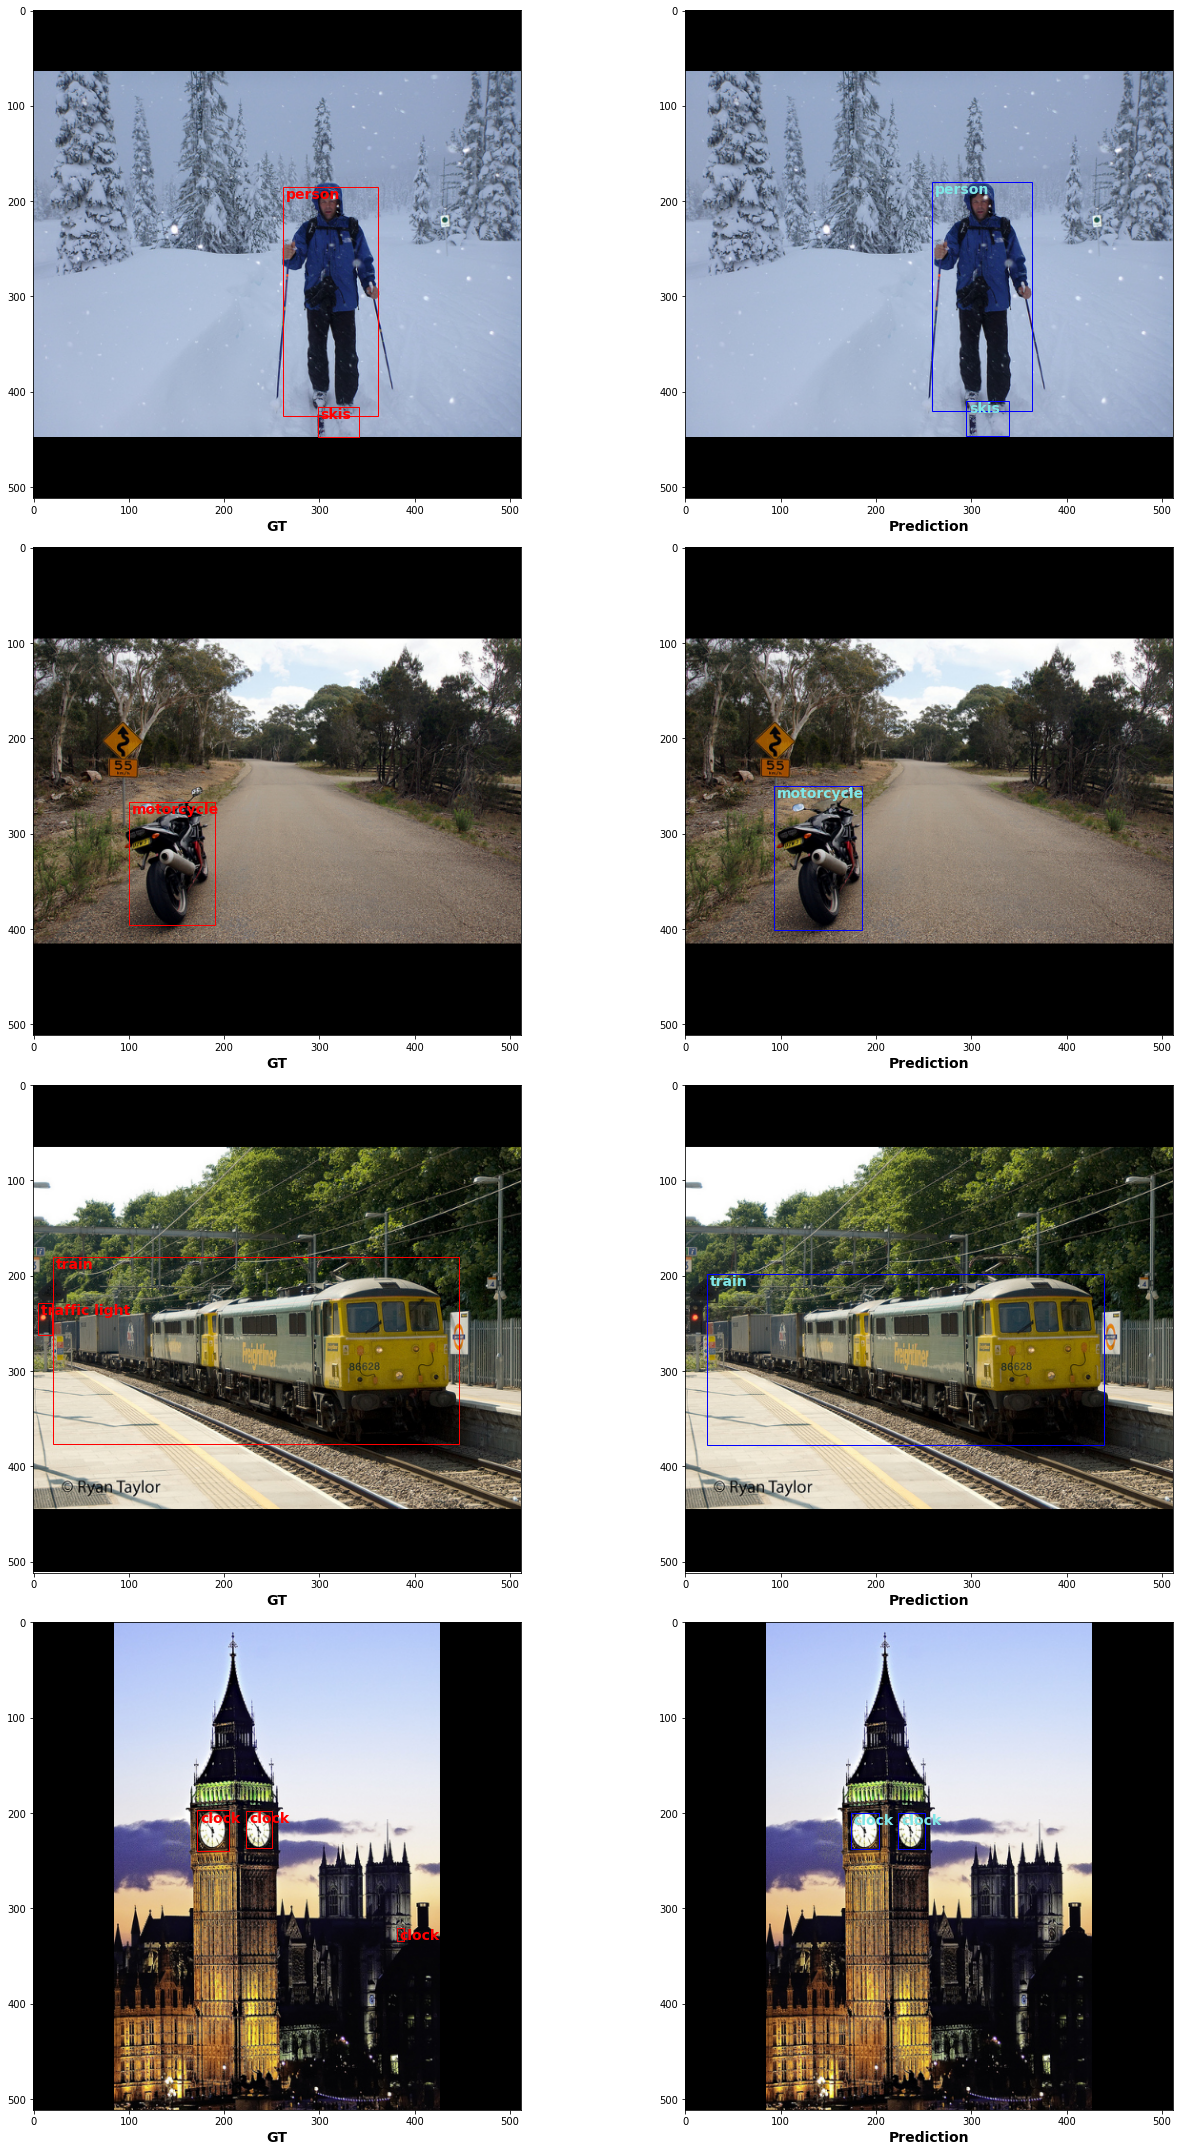

In [41]:
fig, ax = plt.subplots(num_images, 2, figsize=(20, 30))
for batch_index in range(num_images):
    img = network_out['image'].numpy()[batch_index, ...]
    img = ((img + 1) / 2 * 255).astype(np.uint8)
    img = np.transpose(img, [1, 2, 0])

    img2 = img.copy()
    keep = ~np.all(network_out['bbox'][batch_index].numpy() == 0, axis=1)
    gt_x1, gt_y1, gt_w, gt_h, gt_label = network_out['bbox'][batch_index].numpy()[keep].T

    scores = network_out['pred'][batch_index].numpy()[..., -2]
    labels = network_out['pred'][batch_index].numpy()[..., -3]
    keep = scores > 0.5
    x1, y1, w, h, label, _, _ = network_out['pred'][batch_index].numpy()[keep].T

    for i in range(len(gt_x1)):
        rect = patches.Rectangle((gt_x1[i], gt_y1[i]),gt_w[i],gt_h[i],linewidth=1,edgecolor='r',facecolor='none')
        ax[batch_index, 0].add_patch(rect)
        ax[batch_index, 0].set_xlabel('GT', fontsize=14, fontweight='bold')
        ax[batch_index, 0].text(gt_x1[i] + 3,
                   gt_y1[i] + 12,
                   class_map[str(int(gt_label[i])+1)],
                   color=(1, 0, 0),
                   fontsize=14,
                   fontweight='bold')
    for j in range(len(x1)):
        rect = patches.Rectangle((x1[j], y1[j]),w[j],h[j],linewidth=1,edgecolor='b',facecolor='none')
        ax[batch_index, 1].add_patch(rect)
        ax[batch_index, 1].set_xlabel('Prediction', fontsize=14, fontweight='bold')
        ax[batch_index, 1].text(x1[j] + 3, y1[j] + 12, class_map[str(int(label[j]) + 1)], color=(0.5, 0.9, 0.9), fontsize=14, fontweight='bold')

    ax[batch_index, 0].imshow(img)
    ax[batch_index, 1].imshow(img2)

plt.tight_layout()